In [1]:
import sys
import random
import pandas as pd
import numpy as np
from numpy.linalg import svd, matrix_rank, norm
from sklearn import linear_model

import matplotlib.pyplot as plt
import pickle

plt.rcParams.update({'font.size': 14})

In [2]:
# data prep

def removeDuplicated(players, stats):
    """
    players: "../data/nba-players-stats/player_data.csv"
    stats: "../data/nba-players-stats/Seasons_Stats.csv"
    """
    # players with the same name
    names = players.name.unique()
    duplicated = np.array([])

    for name in names:
        numrows = len(players[players.name == name])
        if numrows != 1:
            duplicated = np.append(duplicated, name)

    duplicated = np.sort(duplicated)

    start_year = players.copy()
    start_year = start_year.rename(columns={"name":"Player"})

    # for non-duplicated players
    stats_not_duplicated = stats[~stats.Player.isin(duplicated)]
    stats_not_duplicated = pd.merge(stats_not_duplicated, start_year, on="Player", how="left")

    # only take the values that make sense
    stats_not_duplicated = stats_not_duplicated[(stats_not_duplicated.Year >= stats_not_duplicated.year_start) & (stats_not_duplicated.Year <= stats_not_duplicated.year_end )]
    stats_not_duplicated["year_count"] = stats_not_duplicated.Year - stats_not_duplicated.year_start

    return stats_not_duplicated

def slidingWindowDF(df, window, p=0, save=False):
    """
    df = (dataframe) pivoted df with players in rows, year_count in columns.
    window = (int) sliding window size
    p = (float, 0<=p<=1) fraction of NaN's allowed in each row
    """
    df_final = pd.DataFrame(columns = range(window))
    for i in range(df.shape[1]-window+1):
        df_window = df.iloc[:,i:(i+window)]
        df_window = df_window[np.isnan(df_window).sum(axis=1)/window <= p]
        df_window.columns = range(window)
        df_final = df_final.append(df_window)
    df_final = df_final.sort_index()
    if save==True:
        df_final.to_pickle("../data/nba-players-stats/sliding_window_{}_{}.pkl".format(window,metric))
    return df_final

def getDonorTargetDf(stats_not_duplicated, metric, pred_year, target_id):
    """
    stats_not_duplicated = (dataframe) stats df
    metric = (string) metric of interest (column name of stats_not_duplicated)
    window = (int) sliding window size
    """
    
    # data up to pred_year
    stats_this_year = stats_not_duplicated[stats_not_duplicated.Year <= pred_year]
    
    #target
    stats_target = stats_this_year[stats_this_year.player_id == target_id]
    num_years = stats_target.iloc[-1, -1]
    target_pivot = pd.pivot_table(stats_target, values=metric, columns=['year_count'],index=['Player'])
    if(np.isnan(target_pivot).sum().sum() != 0):
        raise("NaN value in target")

    # donor
    
    stats_donor = stats_this_year[stats_this_year.year_count <= num_years] # only who played more than num_years
    stats_donor = stats_donor[stats_donor.player_id != target_id] 
    donor_pivot = pd.pivot_table(stats_donor, values=metric, columns=['year_count'],index=['Player'])
    donor_pivot = donor_pivot[~donor_pivot[num_years].isnull()]
    donor_pivot = donor_pivot.T.fillna(donor_pivot.mean(axis=1)).T
    
    return donor_pivot, target_pivot

def topPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player","player_id"]][:n]

# plots
def plotPrediction(df_true, df_pred, metric, name, num_sv = 0):
    """
    Plot the groundtruth and prediction of each year.
    (Only the last dot is a test datapoint, all the datapoints before the marker are train datapoints)
    """
    title = "Target Player: "+ name
    if num_sv != 0:
        title = title + "; HSVT: "+ str(num_sv)
    else:
        title = title + "; no HSVT"
    markers_on = [df_true.shape[0]-1]
    plt.plot(df_pred, "blue", marker = 'o', markevery=markers_on)
    plt.plot(df_true, "red", marker = 'o', markevery=markers_on)
    plt.xlabel("year")
    plt.ylabel(metric)
    plt.legend(["Prediction","Truth"])
    plt.title(title)
    plt.show()
    
def plotPredictionEachYear(df_true, df_pred, metric, name, num_sv):
    """
    Plot the groundtruth and prediction of each year. (Each dot means new prediction)
    """
    title = "Target Player: "+ name
    if num_sv != 0:
        title = title + "; HSVT: "+ str(num_sv)
    else:
        title = title + "; no HSVT"
    plt.plot(df_pred, "blue", marker = 'o')
    plt.plot(df_true, "red", marker = 'o')
    # plt.plot(df_numdoner, "grey", linestyle = "dashed")
    plt.xlabel("year")
    plt.ylabel(metric)
    plt.legend(["Prediction","Truth"])
    plt.title(title)
    plt.show()

def plotMape(df_true, df_pred, name, num_sv):
    df_mape = pd.DataFrame(mape(df_true.values, df_pred.values), index = df_true.index)
    
    title = "Target Player: "+ name
    if num_sv != 0:
        title = title + "; HSVT: "+ str(num_sv)
    else:
        title = title + "; no HSVT"
    
    plt.plot(df_mape, "gold", marker = 'o')
    plt.xlabel("year")
    plt.ylabel("MAPE")
    plt.legend(["MAPE", "Doner Pool Size"])
    plt.title(title)
    plt.show()

def plotDonorSize(df_numdonor, name, num_sv):
    df_mape = pd.DataFrame(mape(df_true.values, df_pred.values), index = df_true.index)
    
    title = "Target Player: "+ name
    if num_sv != 0:
        title = title + "; HSVT: "+ str(num_sv)
    else:
        title = title + "; no HSVT"
        
    plt.plot(df_numdonor, "grey", linestyle = "dashed", marker = 'o')
    plt.xlabel("year")
    plt.ylabel("size")
    plt.legend(["Doner Pool Size"])
    plt.title(title)
    plt.show()

In [3]:
def getMetricPerGame(stats, metric, newColName):
    """
    stats: (df) stats dataframe
    metric: (string) column name of stats df
    newColName: (string) new column name for the processed data
    
    output: (df) for each player, for each year, the per-game metric is computed.
    """
    columnsOfInterest = ["year_count", "Player", "G", metric]
    df = stats.loc[:,columnsOfInterest].groupby(["Player","year_count"]).sum()
    df[newColName] = df[metric]/df["G"]
    return df.iloc[:,-1:]

def getMetricsPerGameDict(stats, metrics):
    """
    stats: (df) stats dataframe
    metrics: (list) column names (strings) of stats df
    
    output: (dict) dict of df's.
    """
    metricsPerGameDict = {}
    for metric in metrics:
        newColName = metric+"_G"
        metricsPerGameDict.update({newColName : getMetricPerGame(stats, metric, newColName)})
    return metricsPerGameDict

def getMetricPerCent(stats, metric, newColName):
    """
    recalculating per cent using the metric and metric attempted.
    """
    attempts = metric+"A"
    columnsOfInterest = ["year_count", "Player", metric, attempts]

    df = stats.loc[:,columnsOfInterest].groupby(["Player","year_count"]).sum()
    df[newColName] = df[metric]/df[attempts]
    df.loc[df[attempts] == 0, newColName] = 0    # 0 if no attempt
    return df.iloc[:,-1:]

def getMetricsPerCentDict(stats, metrics):
    metricsPerCentDict = {}
    for metric in metrics:
        newColName = metric+"%"
        metricsPerCentDict.update({newColName : getMetricPerCent(stats, metric, newColName)})
    return metricsPerCentDict

def getMetricsWeighted(stats, metric, newColName):
    """
    weighted average based on the number of games played
    """
    columnsOfInterest = ["year_count", "Player", "G", metric]
    df = stats.loc[:,columnsOfInterest]
    g_sum = stats.loc[:,["Player","year_count","G"]].groupby(["Player","year_count"]).sum().reset_index()
    df = df.merge(g_sum, on=["year_count","Player"], how="left")
    df[newColName] = df[metric]*df["G_x"]/df["G_y"]
    df = df.groupby(["Player","year_count"]).sum().iloc[:,-1:]
    return df

def getMetricsWeightedDict(stats, metrics):
    metricsWeightedDict = {}
    for metric in metrics:
        newColName = metric+"_w"
        metricsWeightedDict.update({newColName : getMetricsWeighted(stats, metric, newColName)})
    return metricsWeightedDict

def getPivotedTable(metric, metricsDict):
    """
    metric: (string) column name of df's in metricsDict
    metricsDict: (dict) df's - in the form of the output of getMetrics~~(stats, metrics)
    
    output: (df) pivoted table with players in rows and year count in columns.
    """
    df = metricsDict[metric].reset_index()
    return pd.pivot_table(df, values=metric, index="Player", columns = "year_count")

def getPivotedTableDict(metricsDict):
    """
    metricsDict: (dict) dict of df's
    """
    pivotedTableDict = {}
    for metric in metricsDict.keys():
        pivotedTableDict.update({metric: getPivotedTable(metric, metricsDict)})
    return pivotedTableDict




def dict_to_list(my_dict, get_keys = False):
    """
    my_dict: (dict) your dictionary
    
    output: (list) values
            (list, list) keys and values if get_keys == True
    """
    if get_keys:
        return list(my_dict.values()), list(my_dict.keys())
    return list(my_dict.values())

def getSlidingWindowList(pivotedTableDict, window):
    """
    outputs sliding window style donor pool
    """
    slidingWindowList = []
    values, keys = dict_to_list(pivotedTableDict, get_keys = True)
    for i in range(len(keys)):
        slidingWindowList.append(slidingWindowDF(values[i], window, p=0, save=False))
    return slidingWindowList


In [8]:
class Target:
    def __init__(self, name, pred_year, stats):
        """
        target_name: (string) target name appears on stats(df)
        pred_year: (int) the year of which you want to make prediction
        stats: (df) seasons-stats.csv file...
        """
        self.name = name
        self.pred_year = pred_year
        self.max_year_count = stats[stats.Player == self.name].iloc[-1,-1].astype(int)
        self.pred_year_count = stats.loc[(stats.Player == self.name) & (stats.Year == self.pred_year), "year_count"].values[0].astype(int)
        
def getTargetData(pivotedTableDict, target):
    targetData = []
    values, keys = dict_to_list(pivotedTableDict, get_keys = True)
    for metric in keys:
        targetData.append(pivotedTableDict[metric].iloc[pivotedTableDict[metric].index == target.name, :(target.pred_year_count+1)])
    return targetData

def removeTarget(donor_list, target_name):
    targetRemoved = []
    for i in range(len(donor_list)):
        targetRemoved.append(donor_list[i].iloc[donor_list[i].index != target_name])
    return targetRemoved

def getTargetNames(stats, pred_year):
    return stats.loc[stats.Year == pred_year, "Player"].unique().tolist()

# Import Data

In [5]:
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980
players["player_id"] = range(0,len(players.name)) # assign id

players.head()

,name,year_start,year_end,position,height,weight,birth_date,college,player_id
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,0
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University,1
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University,2
5,Shareef Abdur-Rahim,1997,2008,F,6-9,225.0,"December 11, 1976",University of California,3
9,Alex Abrines,2017,2018,G-F,6-6,190.0,"August 1, 1993",NaN,4


In [6]:
stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,PTS,year_start,year_end,position,height,weight,birth_date,college,player_id,year_count
0,5733,1980.0,James Bailey,PF,22.0,SEA,67.0,NaN,726.0,12.3,...,312.0,1980,1988,F-C,6-9,220.0,"May 21, 1957",Rutgers University,119,0.0
1,5753,1980.0,Lawrence Boston,PF,23.0,WSB,13.0,NaN,125.0,12.6,...,56.0,1980,1980,F,6-8,225.0,"May 18, 1956",University of Maryland,252,0.0
2,5759,1980.0,Dudley Bradley,SG,22.0,IND,82.0,NaN,2027.0,13.5,...,688.0,1980,1989,G-F,6-6,195.0,"March 19, 1957",University of North Carolina,267,0.0
3,5784,1980.0,Bill Cartwright,C,22.0,NYK,82.0,NaN,3150.0,17.9,...,1781.0,1980,1995,C,7-1,245.0,"July 30, 1957",University of San Francisco,399,0.0
4,5796,1980.0,Jeff Cook,PF,23.0,PHO,66.0,NaN,904.0,14.4,...,362.0,1980,1988,F-C,6-10,215.0,"October 21, 1956",Idaho State University,481,0.0


# Data Prep

In [ ]:
# defMetrics = ["TRB_G","STL_G","BLK_G"]
# defDict = { key: allMetricsDict[key] for key in defMetrics }
# defPivotedTableDict = getPivotedTableDict(defDict)

In [103]:
pred_year = 2017
target = Target("LeBron James", pred_year, stats)

# choose a target among the individuals who played in pred_year
target_names = getTargetNames(stats, pred_year)
# target_name = target_names[200]

##########################################

window = target.pred_year_count + 1

stats_target = stats[stats.Year <= pred_year]
stats_donor = stats[stats.Year < pred_year]

""" target """
# goal is to get the list of all df's; target_df_list
metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK"]
metricsPerGameDict = getMetricsPerGameDict(stats_target, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT","3P"]
metricsPerCentDict = getMetricsPerCentDict(stats_target, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats_target, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}

offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P%"]
offDict = { key: allMetricsDict[key] for key in offMetrics }
offPivotedTableDict = getPivotedTableDict(offDict)

target_df_list = getTargetData(offPivotedTableDict, target)

""" donor """
# goal is to get the list of all df's; donor_df_list
metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK"]
metricsPerGameDict = getMetricsPerGameDict(stats_donor, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT","3P"]
metricsPerCentDict = getMetricsPerCentDict(stats_donor, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats_donor, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}

offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P%"]
offDict = { key: allMetricsDict[key] for key in offMetrics }
offPivotedTableDict = getPivotedTableDict(offDict)

donor_df_list = getSlidingWindowList(offPivotedTableDict, window)
donor_df_list = removeTarget(donor_df_list, target.name)

In [104]:
donor_df_list[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
A.C. Green,6.353659,10.784810,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000
A.C. Green,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000,5.036585,4.475610
A.C. Green,10.784810,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000,5.036585
Al Harrington,2.142857,6.560000,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750
Al Harrington,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750,5.100000,6.617647
Al Harrington,6.560000,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750,5.100000
Amar'e Stoudemire,13.487805,20.600000,26.000000,8.666667,20.378049,25.177215,21.396226,23.121951,25.269231,17.510638,14.241379,11.876923,11.525424,5.769231
Andre Miller,11.146341,15.804878,16.481481,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366
Andre Miller,16.481481,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366,4.879310,4.382716
Andre Miller,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366,4.879310,4.382716,3.692308


In [ ]:
DF_list = getDF(target_df_list, donor_df_list)
trainDF_list = getTrainDF(DF_list)
testDF_list = getTestDF(DF_list)

# DF0 = pd.concat([target_pivot, donor_pivot], axis=0).T
# trainDF0 = DF0.iloc[:-1,:]
# testDF0 = DF0.iloc[-1:,:]

In [71]:
      
def getTargetData(pivotedTableDict, target):
    targetData = []
    values, keys = dict_to_list(pivotedTableDict, get_keys = True)
    for metric in keys:
        targetData.append(pivotedTableDict[metric].iloc[pivotedTableDict[metric].index == target.name, :(target.pred_year_count+1)])
    return targetData

def removeTarget(donor_list, target_name):
    targetRemoved = []
    for i in range(len(donor_list)):
        targetRemoved.append(donor_list[i].iloc[donor_list[i].index != target_name])
    return targetRemoved

def getTargetNames(stats, pred_year):
    return stats.loc[stats.Year == pred_year, "Player"].unique().tolist()

def getDF(target_df_list, donor_df_list):
    """
    donor_df_list: (list) list of df's - not transposed data
    target_df_list: (list) list of df's - not transposed data
    
    output: (list) list of DF's - transposed data with new keys (0 to m)
    """
    DF_list = []
    for i in range(len(df_list)):
        df_list[0]


In [78]:
donor_df_list[0].reset_index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
A.C. Green,6.353659,10.784810,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000
A.C. Green,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000,5.036585,4.475610
A.C. Green,10.784810,11.426829,13.268293,12.939024,9.146341,13.609756,12.817073,14.682927,11.170732,7.463415,7.192771,7.317073,4.920000,5.036585
Al Harrington,2.142857,6.560000,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750
Al Harrington,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750,5.100000,6.617647
Al Harrington,6.560000,7.512821,13.090909,12.219512,13.265823,17.545455,18.565789,16.474359,13.604938,20.123288,17.722222,10.479452,14.218750,5.100000
Amar'e Stoudemire,13.487805,20.600000,26.000000,8.666667,20.378049,25.177215,21.396226,23.121951,25.269231,17.510638,14.241379,11.876923,11.525424,5.769231
Andre Miller,11.146341,15.804878,16.481481,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366
Andre Miller,16.481481,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366,4.879310,4.382716
Andre Miller,13.600000,14.804878,13.573171,13.731707,13.437500,17.048780,16.304878,13.975610,12.703704,9.681818,9.585366,4.879310,4.382716,3.692308


In [ ]:

df_pred = pd.DataFrame()

num_k = len(target_df_list)
relative_weights = [1.0] * num_k
keySeriesLabel = target.name
otherSeriesLabels = range(donor_df_list[0].shape[0])
singvals = 2

# mRSC
mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, len(trainDF0), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel.fit([trainDF0, trainDF1])

# predict
combinedPredictionsArray = mrscmodel.predict([DF0[otherSeriesLabels], DF1[otherSeriesLabels]])

pred0 = combinedPredictionsArray[0]

df_pred0 = df_pred0.append(pd.DataFrame([pred0], index = [pred_year]))


In [92]:
d.std()

0.47543962813298446

In [93]:
np.median(d)

0.24390243902439024

# Distributions

PTS_G
mean:    7.90117212804
median:  6.48356681034
std:     5.64757058043


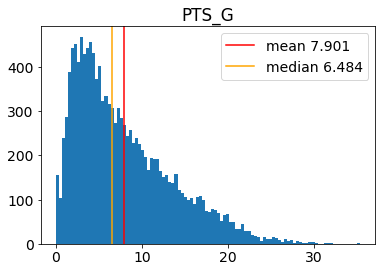

AST_G
mean:    1.79377767257
median:  1.20512820513
std:     1.79147071108


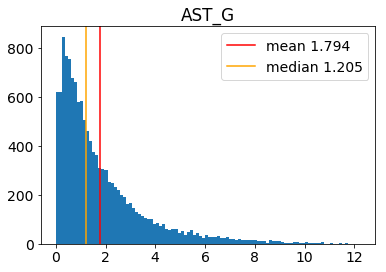

TOV_G
mean:    1.22170959051
median:  1.05755693582
std:     0.777374887141


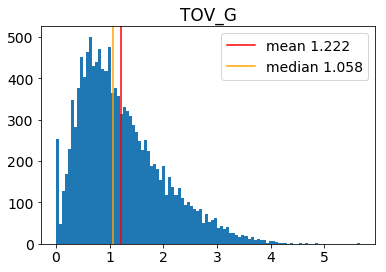

PER_w
mean:    12.4402438847
median:  12.7
std:     5.83911295394


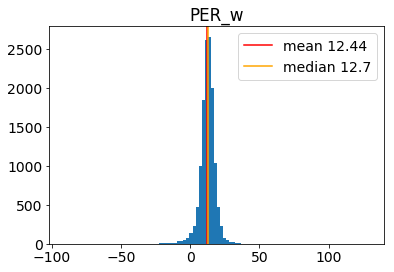

FG%
mean:    0.437742481612
median:  0.443404977772
std:     0.0930927881235


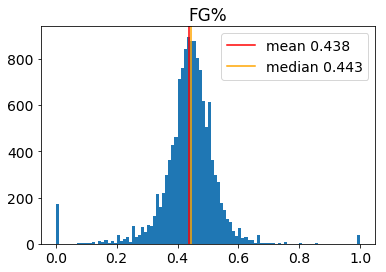

FT%
mean:    0.698327374912
median:  0.74
std:     0.185282654056


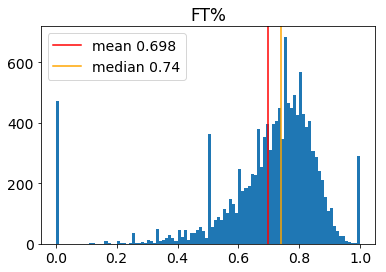

3P%
mean:    0.2078680776
median:  0.25
std:     0.184748627228


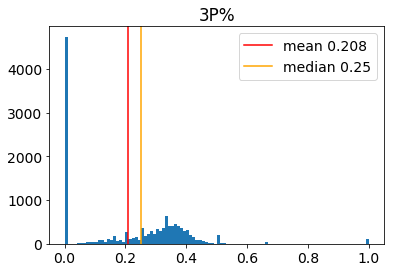

TRB_G
mean:    3.47472465257
median:  2.86585365854
std:     2.45568528434


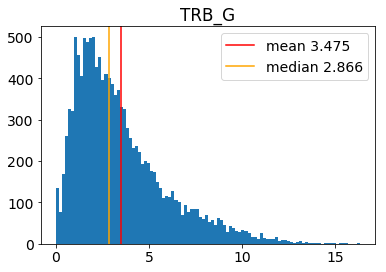

STL_G
mean:    0.653561451358
median:  0.565217391304
std:     0.460083129392


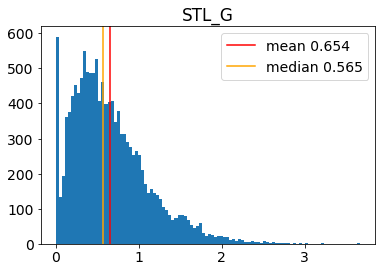

BLK_G
mean:    0.40049616812
median:  0.243902439024
std:     0.475439628133


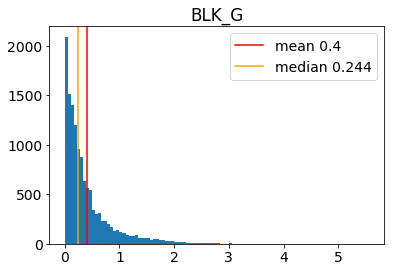

In [102]:
allMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P%","TRB_G","STL_G","BLK_G"]

metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK"]
metricsPerGameDict = getMetricsPerGameDict(stats_donor, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT","3P"]
metricsPerCentDict = getMetricsPerCentDict(stats_donor, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats_donor, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}

for metric in allMetrics:
    d = allMetricsDict[metric].values
    print(metric)
    print("mean:   ", d.mean())
    print("median: ", np.median(d))
    print("std:    ", d.std())
        
    plt.hist(d, bins=100)
    plt.axvline(x=d.mean(), color="r", label='mean {}'.format(d.mean().round(3)))
    plt.axvline(x=np.median(d), color="orange", label='median {}'.format(np.median(d).round(3)))
    plt.legend()
    plt.title(metric)
    plt.show()

In [ ]:
list(offPivotedTableDict.values())
list(offPivotedTableDict.keys())